## Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import shap
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, precision_score, recall_score, precision_recall_curve
random.seed(123)

## Loading data

In [2]:
# Loading data
df = pd.read_csv('RJ/dataset_ML_RJ.csv')
df_tplot = df['tplot']
df_cases = df['CASES_100K']
df = df.drop(columns = ['EPI_YEAR','tplot','CASES_100K'])
df['label_2'] = 0 # for most of values, no epidemic yet
df.loc[df['label'] == 'Epi','label_2'] = 1 # epidemic
df.loc[df['label'] == 'High','label_2'] = 1 # epidemic as well
df = df.drop(columns = ['label'])

## Train-test split

In [3]:
df

,EPI_WEEK,rh_max_lag,rh_min_lag,t_min_lag,t_max_lag,LAMBDA_lag,p_total_lag,label_2
0,16,92.464286,70.000000,24.968571,28.524286,1.228137,52.62,1
1,17,94.912857,68.090000,24.300000,31.317143,1.345211,10.84,1
2,18,92.894286,78.760000,23.490000,30.300000,1.201866,4.80,1
3,19,90.740000,62.778571,22.947143,28.772857,0.967012,22.00,1
4,20,92.072857,62.151429,22.947143,28.820000,0.820011,38.41,1
...,...,...,...,...,...,...,...,...
1076,48,90.722857,66.240000,19.970000,25.234286,0.516667,5.45,0
1077,49,93.990000,60.482857,20.037143,27.360000,0.718667,0.86,0
1078,50,96.062857,57.930000,19.927143,26.128571,0.444444,22.04,0
1079,51,94.481429,58.312857,18.378571,25.864286,0.450544,7.43,0


In [4]:
df['label_2'].value_counts()

0    1008
1      73
Name: label_2, dtype: int64

In [5]:
X = df.iloc[:,0:7]
y = df.iloc[:,7]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test, test_size = 0.5, random_state = 0)

In [6]:
print('Train: ', y_train.shape)
print('Test: ', y_test.shape)
print('Validation: ', y_val.shape)

Train:  (756,)
Test:  (162,)
Validation:  (163,)


## Doing hyperparameter tuning for XGBoost Classifier

In [7]:
hyperparameter_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500, 600],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.05, 0.07, 0.1, 0.2, 0.3],
    'gamma': [0, 0.01, 0.1, 1, 10],
    'min_child_weight': [0, 1, 2]
    }

clx = XGBClassifier(random_state = 0, nthread = 8)
grid = GridSearchCV(clx, hyperparameter_grid, scoring="roc_auc")
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=8,
                                     num_parallel_tree=None, ...),
             param_grid={'gamma': [0, 0.01, 0.1, 1, 10],
                         'learning_rate': [0.05, 0.07, 0.1, 0.2, 0.3],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_child_weight': [0, 1, 2],
                         'n_estimators': [50, 100, 200, 300, 400, 500, 600]},
             scoring='roc_auc')

In [9]:
import joblib
joblib.dump(grid, 'rj_ccm.pkl')

['rj_ccm.pkl']

In [10]:
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.898910380399742 with param: {'gamma': 0, 'learning_rate': 0.07, 'max_depth': 1, 'min_child_weight': 0, 'n_estimators': 50}


### Tuning the threshold

In [11]:
y_val_pred = grid.predict(X_val)
y_val_proba = grid.predict_proba(X_val)[:,1]

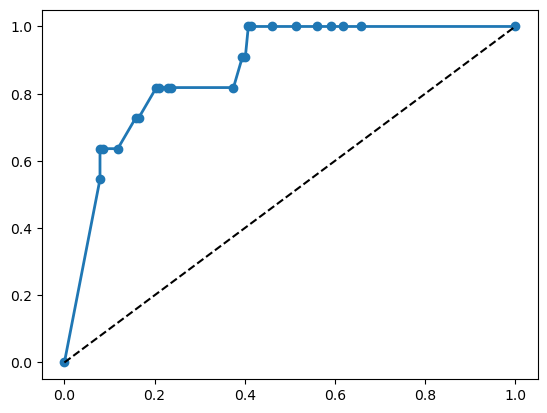

In [12]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba, pos_label = 1)
plt.plot(fpr, tpr, '-o', linewidth=2)
plt.plot([0,1], [0,1], 'k--' )

In [13]:
roc_auc_score(y_val, y_val_proba)

0.8702153110047848

In [14]:
print(fpr)
print(tpr)
print(thresholds)

[0.         0.07894737 0.07894737 0.08552632 0.11842105 0.15789474
 0.16447368 0.20394737 0.21052632 0.23026316 0.23684211 0.375
 0.39473684 0.40131579 0.40789474 0.41447368 0.46052632 0.51315789
 0.55921053 0.59210526 0.61842105 0.65789474 1.        ]
[0.         0.54545455 0.63636364 0.63636364 0.63636364 0.72727273
 0.72727273 0.81818182 0.81818182 0.81818182 0.81818182 0.81818182
 0.90909091 0.90909091 1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]
[1.2862369  0.28623685 0.27264813 0.20944962 0.20219444 0.16889346
 0.15191585 0.12504898 0.11784899 0.09935169 0.08370586 0.08333208
 0.06037362 0.05458155 0.05312553 0.03164591 0.03153056 0.03138178
 0.02953337 0.02028839 0.02016053 0.00887611 0.00732625]


In [15]:
thr_opt = thresholds[np.argmin(abs(tpr-1))]

### Setting threshold and evaluating on test

In [16]:
y_test_pred = grid.predict(X_test)
y_test_proba = grid.predict_proba(X_test)[:,1]
y_test_final = y_test_proba.copy()
y_test_final[y_test_proba >= thr_opt] = 1
y_test_final[y_test_proba < thr_opt] = 0
print(confusion_matrix(y_test, y_test_final))
print('Test Metrics')
print('False Positive Rate: ', 34/(34 + 104))
print('True Positive Rate: ', 12/(12 + 0))

[[94 57]
 [ 0 11]]
Test Metrics
False Positive Rate:  0.2463768115942029
True Positive Rate:  1.0


In [17]:
y_train_pred = grid.predict(X_train)
y_train_proba = grid.predict_proba(X_train)[:,1]
y_train_final = y_train_proba.copy()
y_train_final[y_train_proba >= thr_opt] = 1
y_train_final[y_train_proba < thr_opt] = 0
print(confusion_matrix(y_train, y_train_final))
print('Train Metrics')
print('False Positive Rate: ', 18/(18 + 166))
print('True Positive Rate: ', 16/(16))

[[456 249]
 [  0  51]]
Train Metrics
False Positive Rate:  0.09782608695652174
True Positive Rate:  1.0


In [18]:
y_val_pred = grid.predict(X_val)
y_val_proba = grid.predict_proba(X_val)[:,1]
y_val_final = y_val_proba.copy()
y_val_final[y_val_proba >= thr_opt] = 1
y_val_final[y_val_proba < thr_opt] = 0
print(confusion_matrix(y_val, y_val_final))
print('Validation Metrics')
print('False Positive Rate: ', 18/(18 + 120))
print('True Positive Rate: ', 12/(12 + 0))

[[90 62]
 [ 0 11]]
Validation Metrics
False Positive Rate:  0.13043478260869565
True Positive Rate:  1.0


### Embedded Feature Importance 

Text(0.5, 0, 'Feature Importance')

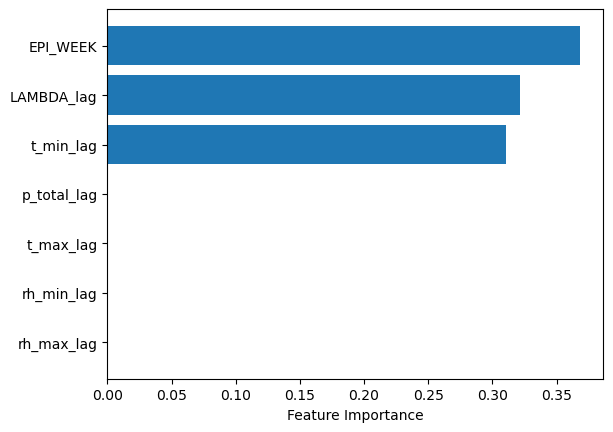

In [19]:
sorted_params = grid.best_estimator_.feature_importances_.argsort()
plt.barh(df.columns[sorted_params], grid.best_estimator_.feature_importances_[sorted_params])
plt.xlabel('Feature Importance')

### SHAP Values

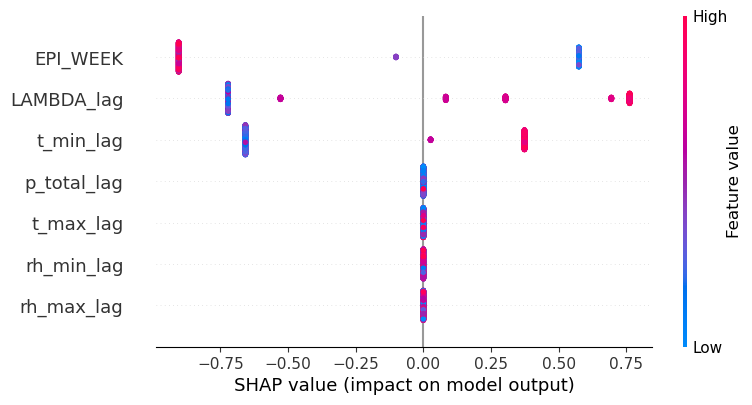

In [20]:
explainer = shap.Explainer(grid.best_estimator_)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)

## Visualizing predictions - where do we fail?

In [21]:
y_pred_proba = grid.predict_proba(X)[:,1]
y_pred_final = y_pred_proba.copy()
y_pred_final[y_pred_proba >= thr_opt] = 1
y_pred_final[y_pred_proba < thr_opt] = 0

In [22]:
confusion_matrix(y, y_pred_final)

array([[640, 368],
       [  0,  73]], dtype=int64)

In [23]:
print('True positive rate: ', 40/(40 + 0))
print('False positive rate: ', 70/(70 + 390))

True positive rate:  1.0
False positive rate:  0.15217391304347827


### False negatives, which is what worries us the most

In [24]:
fn = ((y == 1) & (y_pred_final == 0))
sem_fn = X[fn]

In [25]:
sem_fn

,EPI_WEEK,rh_max_lag,rh_min_lag,t_min_lag,t_max_lag,LAMBDA_lag,p_total_lag


### False positives

In [26]:
fp = ((y == 0) & (y_pred_final == 1))
sem_fp = X[fp]

In [27]:
sem_fp['EPI_WEEK'].value_counts()

22    18
21    18
18    17
20    17
19    17
8     17
17    16
16    16
9     16
10    16
14    15
12    15
5     15
7     15
13    15
11    15
15    14
6     14
3     13
2     13
4     12
1     12
23     8
24     7
26     5
25     4
50     2
27     2
48     1
51     1
28     1
29     1
Name: EPI_WEEK, dtype: int64

### Classifying and labeling each situation

In [28]:
fn = ((y == 1) & (y_pred_final == 0))
fp = ((y == 0) & (y_pred_final == 1))
tn = ((y == 0) & (y_pred_final == 0))
tp = ((y == 1) & (y_pred_final == 1))

In [29]:
Z = X.copy()
Z['label'] = 0

In [30]:
Z.loc[fn,'label'] = 'FN'
Z.loc[fp,'label'] = 'FP'
Z.loc[tn,'label'] = 'TN'
Z.loc[tp, 'label'] = 'TP'

In [31]:
Z['tplot'] = np.array(df_tplot)
Z['CASES_100K'] = np.array(df_cases)

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


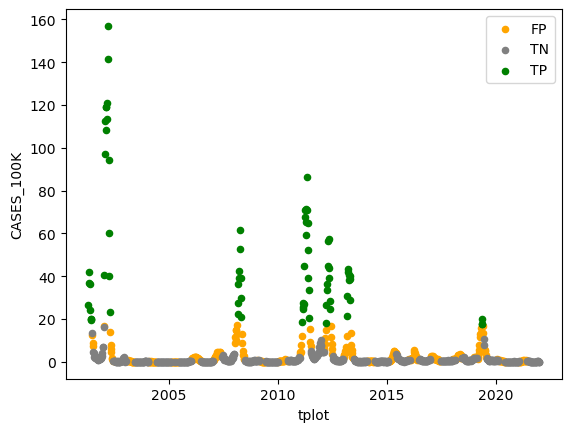

In [32]:
fig, ax = plt.subplots()

colors = {'TP':'green', 'TN':'gray', 'FP':'orange', 'FN':'red'}

grouped = Z.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='tplot', y='CASES_100K', label=key, color=colors[key])

plt.show()

In [33]:
Z['proba'] = y_pred_proba

Text(0, 0.5, 'Count')

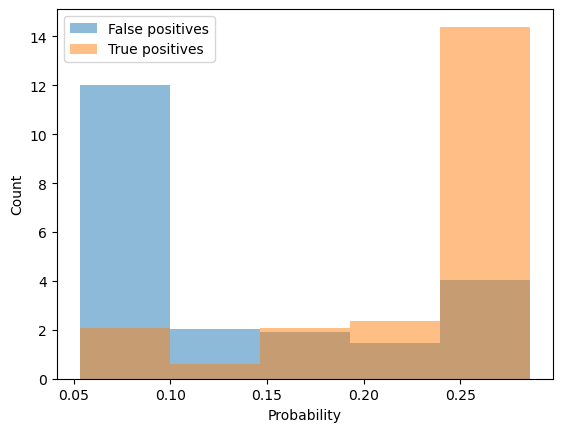

In [34]:
A = Z.copy()
A = A[A['label'] == 'FP']
B = Z.copy()
B = B[B['label'] == 'TP']
C = Z.copy()
C = C[C['label'] == 'TN']
plt.hist(A['proba'], bins = 5, alpha = 0.5, density = True, label = 'False positives')
plt.hist(B['proba'], bins = 5, alpha = 0.5, density = True, label = 'True positives')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Count')

In [35]:
roc_auc_score(y_val, y_val_proba)

0.8702153110047848